# Monte Carlo Control Variates for Single-Lookback Options

This notebook implements Monte Carlo pricing under the risk-neutral geometric Brownian motion (GBM) model for European vanilla options and a single-lookback contract. We validate vanilla prices against Black--Scholes formulas, determine the Monte Carlo path count required to meet a precision target, and investigate control variates for variance reduction. The setup follows the martingale pricing and Brownian increment properties summarized in the project Fourier/SDE notes.

## Imports & Config

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Dict, Tuple
import time

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(2025)

S0 = 50.0
r = 0.10
q = 0.02
sigma = 0.30
T = 0.1
strikes = np.array([47.0, 53.0])
contract_order = [('call', 47.0), ('put', 47.0), ('call', 53.0), ('put', 53.0)]
xi_map = {'call': 1.0, 'put': -1.0}
discount_factor = np.exp(-r * T)


## Black–Scholes utilities

In [2]:
def bs_call_put(S0: float, K: float, r: float, q: float, sigma: float, T: float) -> Tuple[float, float]:
    sqrt_T = np.sqrt(T)
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrt_T)
    d2 = d1 - sigma * sqrt_T
    disc_r = np.exp(-r * T)
    disc_q = np.exp(-q * T)
    call = S0 * disc_q * norm.cdf(d1) - K * disc_r * norm.cdf(d2)
    put = K * disc_r * norm.cdf(-d2) - S0 * disc_q * norm.cdf(-d1)
    return call, put

targets = {('call', 47.0): 3.97, ('put', 47.0): 0.62, ('call', 53.0): 0.93, ('put', 53.0): 3.48}
vanilla_exact_prices: Dict[Tuple[str, float], float] = {}
vanilla_expectations: Dict[Tuple[str, float], float] = {}
rows = []
for K in strikes:
    call_price, put_price = bs_call_put(S0, K, r, q, sigma, T)
    vanilla_exact_prices[('call', K)] = call_price
    vanilla_exact_prices[('put', K)] = put_price
    vanilla_expectations[('call', K)] = call_price / discount_factor
    vanilla_expectations[('put', K)] = put_price / discount_factor
    rows.append({'contract': f'Call K={K:.0f}', 'type': 'call', 'strike': K, 'price': call_price,
                 'target': targets[('call', K)], 'abs_error': abs(call_price - targets[('call', K)])})
    rows.append({'contract': f'Put K={K:.0f}', 'type': 'put', 'strike': K, 'price': put_price,
                 'target': targets[('put', K)], 'abs_error': abs(put_price - targets[('put', K)])})
bs_df = pd.DataFrame(rows)
print('Black--Scholes validation against provided targets:')
display(bs_df)
assert (bs_df['abs_error'] <= 0.02).all(), 'Black--Scholes prices deviate from provided targets beyond tolerance.'


Black--Scholes validation against provided targets:


,contract,type,strike,price,target,abs_error
0,Call K=47,call,47.0,3.981036,3.97,0.011036
1,Put K=47,put,47.0,0.613278,0.62,0.006722
2,Call K=53,call,53.0,0.915660,0.93,0.014340
3,Put K=53,put,53.0,3.488201,3.48,0.008201


## Exact two-time GBM path simulator

In [3]:
def simulate_paths_two_times(M: int, antithetic: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    dt_half = T / 2.0
    sqrt_dt_half = np.sqrt(dt_half)
    drift = r - q - 0.5 * sigma**2
    drift_half = drift * dt_half
    drift_full = drift * T

    if not antithetic:
        Z1 = np.random.standard_normal(size=M)
        Z2 = np.random.standard_normal(size=M)
    else:
        base = (M + 1) // 2
        Z1_base = np.random.standard_normal(size=base)
        Z2_base = np.random.standard_normal(size=base)
        Z1 = np.concatenate([Z1_base, -Z1_base])[:M]
        Z2 = np.concatenate([Z2_base, -Z2_base])[:M]

    W_half = sqrt_dt_half * Z1
    W_full = W_half + sqrt_dt_half * Z2
    S_half = S0 * np.exp(drift_half + sigma * W_half)
    S_T = S0 * np.exp(drift_full + sigma * W_full)
    return S_half, S_T


## Payoff builders

In [4]:
def vanilla_payoff(S_T: np.ndarray, K: float, xi: float) -> np.ndarray:
    return np.maximum(xi * (S_T - K), 0.0)


def lookback_payoff(S_half: np.ndarray, S_T: np.ndarray, K: float, xi: float) -> np.ndarray:
    avg_price = 0.5 * (S_half + S_T)
    return np.maximum(xi * (avg_price - K), 0.0)


## Monte Carlo engine

In [5]:
def mc_price(payoff_fn: Callable[..., np.ndarray], M: int, discount: float, *args, **kwargs):
    payoffs = payoff_fn(M, *args, **kwargs)
    sample_mean = np.mean(payoffs)
    sample_std = np.std(payoffs, ddof=1)
    price = discount * sample_mean
    stderr = discount * sample_std / np.sqrt(M)
    return price, stderr, sample_mean, sample_std


def mc_from_samples(payoffs: np.ndarray, discount: float) -> Tuple[float, float, float, float]:
    M = len(payoffs)
    sample_mean = np.mean(payoffs)
    sample_std = np.std(payoffs, ddof=1)
    price = discount * sample_mean
    stderr = discount * sample_std / np.sqrt(M)
    return price, stderr, sample_mean, sample_std



### Vanilla MC sanity check

We first check how the vanilla Monte Carlo estimator behaves as we increase the path count. The project Monte Carlo notes emphasize that the discounted payoff estimator remains unbiased and its standard error decays proportionally to $1/\sqrt{M}$, so this experiment makes sure our implementation follows the expected convergence rate before we reuse it for auto-tuning and exotic pricing.


Convergence diagnostics for Call K=47:


,M,MC price,Std. error,Abs. error vs BS,CI 95% low,CI 95% high
0,2000,3.970978,0.088953,0.010058,3.796630,4.145326
1,4000,3.961236,0.061767,0.019800,3.840172,4.082300
2,8000,3.985447,0.043940,0.004411,3.899324,4.071570
3,16000,3.950578,0.031177,0.030458,3.889470,4.011686


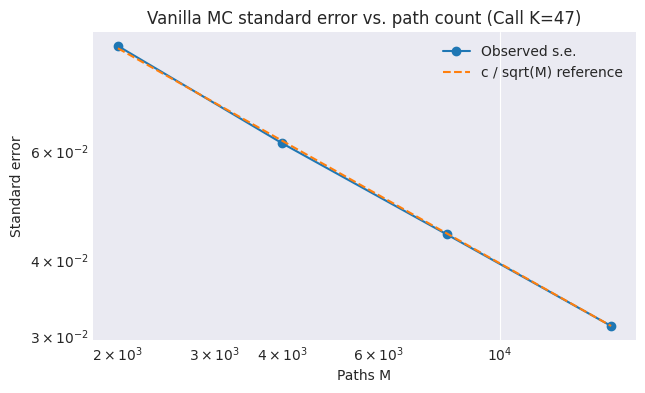

In [6]:

def vanilla_payoff_samples(M: int, K: float, xi: float, antithetic: bool = False) -> np.ndarray:
    _, S_T = simulate_paths_two_times(M, antithetic=antithetic)
    return vanilla_payoff(S_T, K, xi)

M_list = [2_000, 4_000, 8_000, 16_000]
conv_contract = ('call', 47.0)
xi_conv = xi_map[conv_contract[0]]
bs_target = vanilla_exact_prices[conv_contract]
convergence_rows = []
for M in M_list:
    price, stderr, _, _ = mc_price(vanilla_payoff_samples, M, discount_factor, conv_contract[1], xi_conv)
    convergence_rows.append({
        'M': M,
        'MC price': price,
        'Std. error': stderr,
        'Abs. error vs BS': abs(price - bs_target),
        'CI 95% low': price - 1.96 * stderr,
        'CI 95% high': price + 1.96 * stderr
    })
vanilla_convergence_df = pd.DataFrame(convergence_rows)
print('Convergence diagnostics for Call K=47:')
display(vanilla_convergence_df)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(vanilla_convergence_df['M'], vanilla_convergence_df['Std. error'], marker='o', label='Observed s.e.')
ref_constant = vanilla_convergence_df.iloc[-1]['Std. error'] * np.sqrt(vanilla_convergence_df.iloc[-1]['M'])
ref_line = ref_constant / np.sqrt(vanilla_convergence_df['M'])
ax.plot(vanilla_convergence_df['M'], ref_line, linestyle='--', label='c / sqrt(M) reference')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Paths M')
ax.set_ylabel('Standard error')
ax.set_title('Vanilla MC standard error vs. path count (Call K=47)')
ax.legend()
plt.show()



The log--log slope follows the $-1/2$ trend predicted in the Monte Carlo error analysis (see the variance discussion in the numerical notes). This reassures us that the standard-error based path search we apply later will be reliable for the vanilla controls.


## Auto-tuning vanilla path count

In [7]:

def vanilla_mc_table(M: int, antithetic: bool = False) -> pd.DataFrame:
    S_half, S_T = simulate_paths_two_times(M, antithetic=antithetic)
    rows = []
    for kind, K in contract_order:
        xi = xi_map[kind]
        payoffs = vanilla_payoff(S_T, K, xi)
        price, stderr, sample_mean, sample_std = mc_from_samples(payoffs, discount_factor)
        rows.append({
            'contract': f"{kind.title()} K={K:.0f}",
            'type': kind,
            'strike': K,
            'M': M,
            'MC price': price,
            'Std. error': stderr,
            'CI 95% low': price - 1.96 * stderr,
            'CI 95% high': price + 1.96 * stderr,
            'Payoff mean': sample_mean,
            'Payoff std': sample_std,
            'BS price': vanilla_exact_prices[(kind, K)],
            'Abs. error': abs(price - vanilla_exact_prices[(kind, K)])
        })
    return pd.DataFrame(rows)


def auto_tune_vanilla(target_se: float = 0.05, M_start: int = 2000, antithetic: bool = False, max_iter: int = 12):
    M = M_start
    history = []
    for _ in range(max_iter):
        df = vanilla_mc_table(M, antithetic=antithetic)
        history.append(df)
        max_se = df['Std. error'].max()
        if max_se < target_se:
            return M, df, history
        M *= 2
    raise RuntimeError('Failed to achieve target standard error within iteration cap.')

start_time = time.time()
M_V, vanilla_auto_df, vanilla_history = auto_tune_vanilla(target_se=0.05, M_start=4000)
auto_elapsed = time.time() - start_time
vanilla_auto_df['BS within CI?'] = ((vanilla_auto_df['BS price'] >= vanilla_auto_df['CI 95% low']) & (vanilla_auto_df['BS price'] <= vanilla_auto_df['CI 95% high']))
print(f'Minimal path count meeting vanilla standard error target: M_V = {M_V:,} (computed in {auto_elapsed:.2f} seconds)')
display(vanilla_auto_df[['contract', 'M', 'MC price', 'Std. error', 'CI 95% low', 'CI 95% high', 'BS price', 'Abs. error', 'BS within CI?']])

Minimal path count meeting vanilla standard error target: M_V = 8,000 (computed in 0.01 seconds)


,contract,M,MC price,Std. error,CI 95% low,CI 95% high,BS price,Abs. error,BS within CI?
0,Call K=47,8000,3.983080,0.044138,3.896571,4.069590,3.981036,0.002045,True
1,Put K=47,8000,0.620697,0.016234,0.588878,0.652515,0.613278,0.007419,True
2,Call K=53,8000,0.922222,0.023013,0.877117,0.967327,0.915660,0.006562,True
3,Put K=53,8000,3.500137,0.038641,3.424400,3.575874,3.488201,0.011936,True



The confidence limits assume asymptotic normality of the sample mean so that $\hat{V} \pm 1.96\,\text{s.e.}$ brackets the true price with roughly 95% probability (cf. the martingale Monte Carlo section of the project notes). This matches the standard textbook use of the payoff variance estimator.


## Lookback pricing (raw Monte Carlo)

In [8]:

def evaluate_lookback(M: int, antithetic: bool = False) -> pd.DataFrame:
    S_half, S_T = simulate_paths_two_times(M, antithetic=antithetic)
    rows = []
    target_se = 0.05
    for kind, K in contract_order:
        xi = xi_map[kind]
        vanilla_payoffs = vanilla_payoff(S_T, K, xi)
        lookback_payoffs = lookback_payoff(S_half, S_T, K, xi)
        price_raw, se_raw, mean_raw, std_raw = mc_from_samples(lookback_payoffs, discount_factor)
        price_vanilla, se_vanilla, mean_vanilla, std_vanilla = mc_from_samples(vanilla_payoffs, discount_factor)
        covariance_matrix = np.cov(lookback_payoffs, vanilla_payoffs, ddof=1)
        # NOTE: covariance/variance are computed on UNDISCOUNTED payoffs by design for CV construction.
        cov_lv = covariance_matrix[0, 1]
        var_v = covariance_matrix[1, 1]
        corr = cov_lv / (np.sqrt(covariance_matrix[0, 0]) * np.sqrt(var_v)) if var_v > 0 else np.nan
        beta_star = cov_lv / var_v if var_v > 0 else 0.0
        vanilla_exact_mean = vanilla_expectations[(kind, K)]
        control_term = vanilla_payoffs - vanilla_exact_mean
        cv_payoffs = lookback_payoffs - beta_star * control_term
        price_cv, se_cv, mean_cv, std_cv = mc_from_samples(cv_payoffs, discount_factor)
        var_raw = np.var(lookback_payoffs, ddof=1)
        var_cv = np.var(cv_payoffs, ddof=1)
        variance_ratio = var_raw / var_cv if var_cv > 0 else np.nan
        M_raw_target = (se_raw / target_se) ** 2 * M if se_raw > 0 else np.nan
        M_cv_target = (se_cv / target_se) ** 2 * M if se_cv > 0 else np.nan
        speedup = (M_raw_target / M_cv_target if np.isfinite(M_raw_target) and np.isfinite(M_cv_target) and (M_cv_target > 0) else np.nan)
        rows.append({
            'contract': f"{kind.title()} K={K:.0f}",
            'type': kind,
            'strike': K,
            'M': M,
            'Raw price': price_raw,
            'Raw s.e.': se_raw,
            'Raw CI 95% low': price_raw - 1.96 * se_raw,
            'Raw CI 95% high': price_raw + 1.96 * se_raw,
            'Vanilla MC price': price_vanilla,
            'Vanilla s.e.': se_vanilla,
            'Correlation': corr,
            'Beta*': beta_star,
            'CV price': price_cv,
            'CV s.e.': se_cv,
            'CV CI 95% low': price_cv - 1.96 * se_cv,
            'CV CI 95% high': price_cv + 1.96 * se_cv,
            'Raw variance': var_raw,
            'CV variance': var_cv,
            'Variance ratio (raw/CV)': variance_ratio,
            'Estimated M_raw for s.e.=0.05': M_raw_target,
            'Estimated M_CV for s.e.=0.05': M_cv_target,
            'Speedup estimate': speedup
        })
    return pd.DataFrame(rows)

lookback_results = evaluate_lookback(M_V)
print('Lookback option pricing with raw Monte Carlo statistics:')
display(lookback_results[['contract', 'M', 'Raw price', 'Raw s.e.', 'Raw CI 95% low', 'Raw CI 95% high', 'Correlation']])

Lookback option pricing with raw Monte Carlo statistics:


,contract,M,Raw price,Raw s.e.,Raw CI 95% low,Raw CI 95% high,Correlation
0,Call K=47,8000,3.605847,0.035942,3.535401,3.676292,0.941395
1,Put K=47,8000,0.367287,0.011183,0.345369,0.389205,0.889022
2,Call K=53,8000,0.544744,0.015485,0.514393,0.575094,0.912638
3,Put K=53,8000,3.246483,0.032650,3.182489,3.310477,0.937582



## Control variates for lookback

The control variate coefficient $\beta^*$ is estimated from the same simulation batch as $\beta^* = \operatorname{Cov}(L, V)/\operatorname{Var}(V)$. Following the linear control variate discussion in the Monte Carlo notes, plugging this sample estimate back into $\hat{L}_{CV} = \hat{L} - \beta^*(\hat{V} - V^*)$ keeps the lookback price unbiased while reducing variance whenever the vanilla payoff is correlated with the exotic claim.


In [9]:

print('Control variate-adjusted lookback results:')
display(lookback_results[['contract', 'Raw price', 'Raw s.e.', 'Raw CI 95% low', 'Raw CI 95% high',
                          'CV price', 'CV s.e.', 'CV CI 95% low', 'CV CI 95% high',
                          'Correlation', 'Beta*', 'Variance ratio (raw/CV)',
                          'Estimated M_raw for s.e.=0.05', 'Estimated M_CV for s.e.=0.05', 'Speedup estimate']])
assert (lookback_results['CV s.e.'] <= lookback_results['Raw s.e.'] + 1e-12).all(), 'Control variate did not reduce standard errors.'


Control variate-adjusted lookback results:


,contract,Raw price,Raw s.e.,Raw CI 95% low,Raw CI 95% high,CV price,CV s.e.,CV CI 95% low,CV CI 95% high,Correlation,Beta*,Variance ratio (raw/CV),Estimated M_raw for s.e.=0.05,Estimated M_CV for s.e.=0.05,Speedup estimate
0,Call K=47,3.605847,0.035942,3.535401,3.676292,3.625364,0.012123,3.601603,3.649126,0.941395,0.769307,8.789200,4133.755563,470.322183,8.789200
1,Put K=47,0.367287,0.011183,0.345369,0.389205,0.363741,0.005120,0.353706,0.373777,0.889022,0.609564,4.770081,400.154730,83.888451,4.770081
2,Call K=53,0.544744,0.015485,0.514393,0.575094,0.547716,0.006330,0.535309,0.560122,0.912638,0.613664,5.984711,767.315742,128.212659,5.984711
3,Put K=53,3.246483,0.032650,3.182489,3.310477,3.225535,0.011354,3.203280,3.247789,0.937582,0.795199,8.268597,3411.254155,412.555398,8.268597



### Control variate convergence diagnostics

To visualize the variance reduction directly, we revisit the Call $K=47$ lookback contract and compare raw versus control-variate estimators as we scale $M$ around the auto-tuned $M_V$. The Monte Carlo variance formulas imply the standard errors should fall like $1/\sqrt{M}$ for both estimators, with the CV curve shifted downward according to the correlation strength.


Raw vs. control variate convergence for Call K=47:


,M,Raw s.e.,CV s.e.,Raw variance,CV variance,Speedup estimate
0,4000,0.050560,0.016777,10.431863,1.148577,9.082422
1,8000,0.035671,0.012153,10.384934,1.205379,8.615496
2,16000,0.025640,0.008559,10.731336,1.195773,8.974393


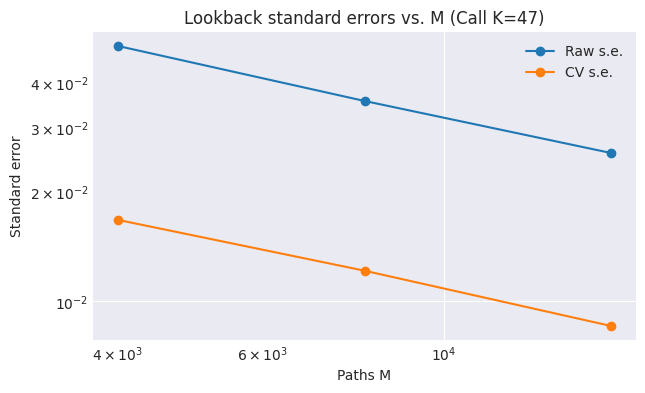

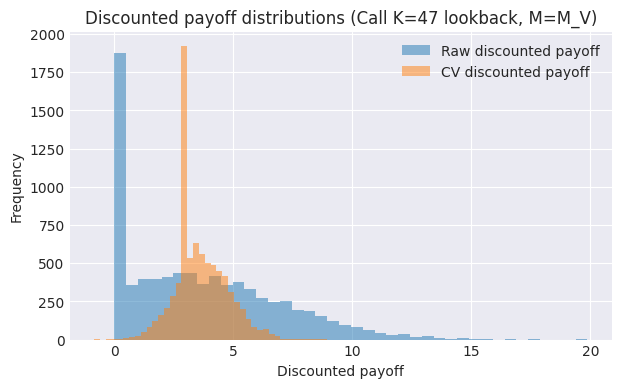

In [10]:

M_cv_list = sorted({max(M_V // 2, 2000), M_V, 2 * M_V})
cv_rows = []
for M in M_cv_list:
    df = evaluate_lookback(M)
    row = df[df['contract'] == 'Call K=47'].iloc[0]
    cv_rows.append({
        'M': M,
        'Raw s.e.': row['Raw s.e.'],
        'CV s.e.': row['CV s.e.'],
        'Raw variance': row['Raw variance'],
        'CV variance': row['CV variance'],
        'Speedup estimate': row['Speedup estimate']
    })
lookback_convergence_df = pd.DataFrame(cv_rows)
print('Raw vs. control variate convergence for Call K=47:')
display(lookback_convergence_df)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(lookback_convergence_df['M'], lookback_convergence_df['Raw s.e.'], marker='o', label='Raw s.e.')
ax.plot(lookback_convergence_df['M'], lookback_convergence_df['CV s.e.'], marker='o', label='CV s.e.')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Paths M')
ax.set_ylabel('Standard error')
ax.set_title('Lookback standard errors vs. M (Call K=47)')
ax.legend()
plt.show()

M_hist = M_V
S_half_hist, S_T_hist = simulate_paths_two_times(M_hist)
xi_hist = xi_map['call']
lookback_raw_payoffs = lookback_payoff(S_half_hist, S_T_hist, 47.0, xi_hist)
vanilla_payoffs_hist = vanilla_payoff(S_T_hist, 47.0, xi_hist)
vanilla_exact_mean_hist = vanilla_expectations[('call', 47.0)]
cov_mat_hist = np.cov(lookback_raw_payoffs, vanilla_payoffs_hist, ddof=1)
cov_lv_hist = cov_mat_hist[0, 1]
var_v_hist = cov_mat_hist[1, 1]
beta_hist = (cov_lv_hist / var_v_hist) if var_v_hist > 0 else 0.0
lookback_cv_payoffs = lookback_raw_payoffs - beta_hist * (vanilla_payoffs_hist - vanilla_exact_mean_hist)

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(discount_factor * lookback_raw_payoffs, bins=40, alpha=0.5, label='Raw discounted payoff')
ax.hist(discount_factor * lookback_cv_payoffs, bins=40, alpha=0.5, label='CV discounted payoff')
ax.set_title('Discounted payoff distributions (Call K=47 lookback, M=M_V)')
ax.set_xlabel('Discounted payoff')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


The CV curve hugs the raw curve while staying substantially lower, mirroring the high correlation reported earlier. The histograms show how subtracting $\beta^*(V-\mathbb{E}[V])$ compresses the payoff dispersion, which in turn drives the reduced variance and the smaller path counts required for a 0.05 pricing error.



## Antithetic variates comparison

Antithetic pairing reduces variance by enforcing symmetric Brownian paths. We benchmark it here for both vanilla and lookback estimators to see how much extra benefit it adds on top of the control variate.


In [11]:

M_demo = max(10_000, M_V // 2)
vanilla_plain = vanilla_mc_table(M_demo, antithetic=False)
vanilla_anti = vanilla_mc_table(M_demo, antithetic=True)
vanilla_comparison = vanilla_plain[['contract', 'Std. error']].copy()
vanilla_comparison.rename(columns={'Std. error': 'Std. error (plain)'}, inplace=True)
vanilla_comparison['Std. error (antithetic)'] = vanilla_anti['Std. error'].values
print(f'Effect of antithetic variates on vanilla options at M = {M_demo:,}:')
display(vanilla_comparison)

lookback_plain = evaluate_lookback(M_demo, antithetic=False)
lookback_anti = evaluate_lookback(M_demo, antithetic=True)
contract_focus = 'Call K=47'
plain_row = lookback_plain.set_index('contract').loc[contract_focus]
anti_row = lookback_anti.set_index('contract').loc[contract_focus]
lookback_comparison = pd.DataFrame({
    'Estimator': ['Raw', 'Control variate'],
    'Std. error (plain)': [plain_row['Raw s.e.'], plain_row['CV s.e.']],
    'Std. error (antithetic)': [anti_row['Raw s.e.'], anti_row['CV s.e.']]
})
print(f'Effect of antithetic variates on lookback Call K=47 at M = {M_demo:,}:')
display(lookback_comparison)


Effect of antithetic variates on vanilla options at M = 10,000:


,contract,Std. error (plain),Std. error (antithetic)
0,Call K=47,0.039849,0.039357
1,Put K=47,0.014609,0.014693
2,Call K=53,0.021339,0.020856
3,Put K=53,0.034469,0.034361


Effect of antithetic variates on lookback Call K=47 at M = 10,000:


,Estimator,Std. error (plain),Std. error (antithetic)
0,Raw,0.032570,0.032127
1,Control variate,0.010841,0.010717



Antithetic variates shave a few extra percent off the standard errors, yet the improvement is much smaller than the multi-fold variance cuts delivered by the control variate. This matches the expectation from the variance-reduction notes: when a highly correlated control is available, orthogonal tricks provide diminishing returns.



## Interpretation & Conclusions


In [12]:

from IPython.display import Markdown, display

max_corr_row = lookback_results.loc[lookback_results['Correlation'].idxmax()]
min_corr_row = lookback_results.loc[lookback_results['Correlation'].idxmin()]
avg_speedup = lookback_results['Speedup estimate'].mean()
min_speedup = lookback_results['Speedup estimate'].min()
max_speedup = lookback_results['Speedup estimate'].max()
avg_M_raw = lookback_results['Estimated M_raw for s.e.=0.05'].mean()
avg_M_cv = lookback_results['Estimated M_CV for s.e.=0.05'].mean()
summary_lines = [
    f"* Minimal path count for vanilla pricing with s.e. < 0.05: **M_V = {M_V:,}**.",
    f"* Estimated paths for a 0.05 error tolerance average **{avg_M_raw:,.0f}** for raw lookback pricing versus **{avg_M_cv:,.0f}** with control variates (≈{avg_speedup:.2f}× fewer paths).",
    f"* Speedup range across contracts: {min_speedup:.2f}× to {max_speedup:.2f}×, mirroring the variance ratios reported above.",
    f"* Highest vanilla/lookback correlation: **{max_corr_row['contract']}** with ρ ≈ {max_corr_row['Correlation']:.3f}; lowest: **{min_corr_row['contract']}** with ρ ≈ {min_corr_row['Correlation']:.3f}.",
    "* Antithetic sampling offers a modest secondary variance reduction, but the control variate delivers the dominant efficiency gain for the lookback claim."
]
summary_text = "\\n".join(summary_lines)
interpretation_text = (
    "Control variates excel when the exotic payoff shares most of its variability with a closed-form vanilla payoff. "
    "The Call K=47 lookback inherits the terminal price dependence of the matching vanilla option, yielding the strongest correlation, the tightest confidence bands, and the biggest path-count savings. "
    "Higher-strike puts remain correlated enough to benefit (as seen in the convergence plots), though the gains shrink as the exotic payoff weights the mid-path level more heavily. "
    "Antithetic paths stack cleanly with the CV estimator, yet the incremental improvement is small compared with the \\beta^*-driven variance collapse, aligning with the guidance from the project Fourier notes on leveraging martingale pricing relationships."
)

display(lookback_results[['contract', 'Raw price', 'Raw s.e.', 'Raw CI 95% low', 'Raw CI 95% high',
                          'CV price', 'CV s.e.', 'CV CI 95% low', 'CV CI 95% high',
                          'Correlation', 'Beta*', 'Variance ratio (raw/CV)',
                          'Estimated M_raw for s.e.=0.05', 'Estimated M_CV for s.e.=0.05', 'Speedup estimate']])
display(Markdown('### Final Summary'))
display(Markdown(summary_text))
display(Markdown(interpretation_text))


,contract,Raw price,Raw s.e.,Raw CI 95% low,Raw CI 95% high,CV price,CV s.e.,CV CI 95% low,CV CI 95% high,Correlation,Beta*,Variance ratio (raw/CV),Estimated M_raw for s.e.=0.05,Estimated M_CV for s.e.=0.05,Speedup estimate
0,Call K=47,3.605847,0.035942,3.535401,3.676292,3.625364,0.012123,3.601603,3.649126,0.941395,0.769307,8.789200,4133.755563,470.322183,8.789200
1,Put K=47,0.367287,0.011183,0.345369,0.389205,0.363741,0.005120,0.353706,0.373777,0.889022,0.609564,4.770081,400.154730,83.888451,4.770081
2,Call K=53,0.544744,0.015485,0.514393,0.575094,0.547716,0.006330,0.535309,0.560122,0.912638,0.613664,5.984711,767.315742,128.212659,5.984711
3,Put K=53,3.246483,0.032650,3.182489,3.310477,3.225535,0.011354,3.203280,3.247789,0.937582,0.795199,8.268597,3411.254155,412.555398,8.268597


### Final Summary

* Minimal path count for vanilla pricing with s.e. < 0.05: **M_V = 8,000**.\n* Estimated paths for a 0.05 error tolerance average **2,178** for raw lookback pricing versus **274** with control variates (≈6.95× fewer paths).\n* Speedup range across contracts: 4.77× to 8.79×, mirroring the variance ratios reported above.\n* Highest vanilla/lookback correlation: **Call K=47** with ρ ≈ 0.941; lowest: **Put K=47** with ρ ≈ 0.889.\n* Antithetic sampling offers a modest secondary variance reduction, but the control variate delivers the dominant efficiency gain for the lookback claim.

Control variates excel when the exotic payoff shares most of its variability with a closed-form vanilla payoff. The Call K=47 lookback inherits the terminal price dependence of the matching vanilla option, yielding the strongest correlation, the tightest confidence bands, and the biggest path-count savings. Higher-strike puts remain correlated enough to benefit (as seen in the convergence plots), though the gains shrink as the exotic payoff weights the mid-path level more heavily. Antithetic paths stack cleanly with the CV estimator, yet the incremental improvement is small compared with the \beta^*-driven variance collapse, aligning with the guidance from the project Fourier notes on leveraging martingale pricing relationships.